In [177]:
import pandas as pd
import plotly.graph_objects as go

import sys
sys.path.append('../_styling/')
from style import prep_plot, BLACK, GRAY1, GRAY2, GRAY3

In [186]:
# Read and transform the data a bit
df = pd.read_csv("oss_funding.csv", index_col=0)
df['funder_round_type'] = df.apply(lambda x: 
    x['funder_round_name'] if x['funder_name'] == 'Optimism Foundation' else x['funder_round_type']
    , axis=1)
df.rename(columns={
    'funder_name': 'oss_funding_program', 
    'funder_round_type': 'funding_mechanism',
    'project_name_mapping': 'oss_project'
}, inplace=True)
df.drop(columns=['funder_round_name'], inplace=True)

val_col = df.columns[-1]
cat_cols = list(df.columns)[:-1]
df = df.groupby(cat_cols)[val_col].sum().sort_values(ascending=False).reset_index()

df.head(1)

,oss_funding_program,funding_mechanism,oss_project,funding_usd
0,Optimism Foundation,RetroPGF3,Protocol Guild,2323487.67


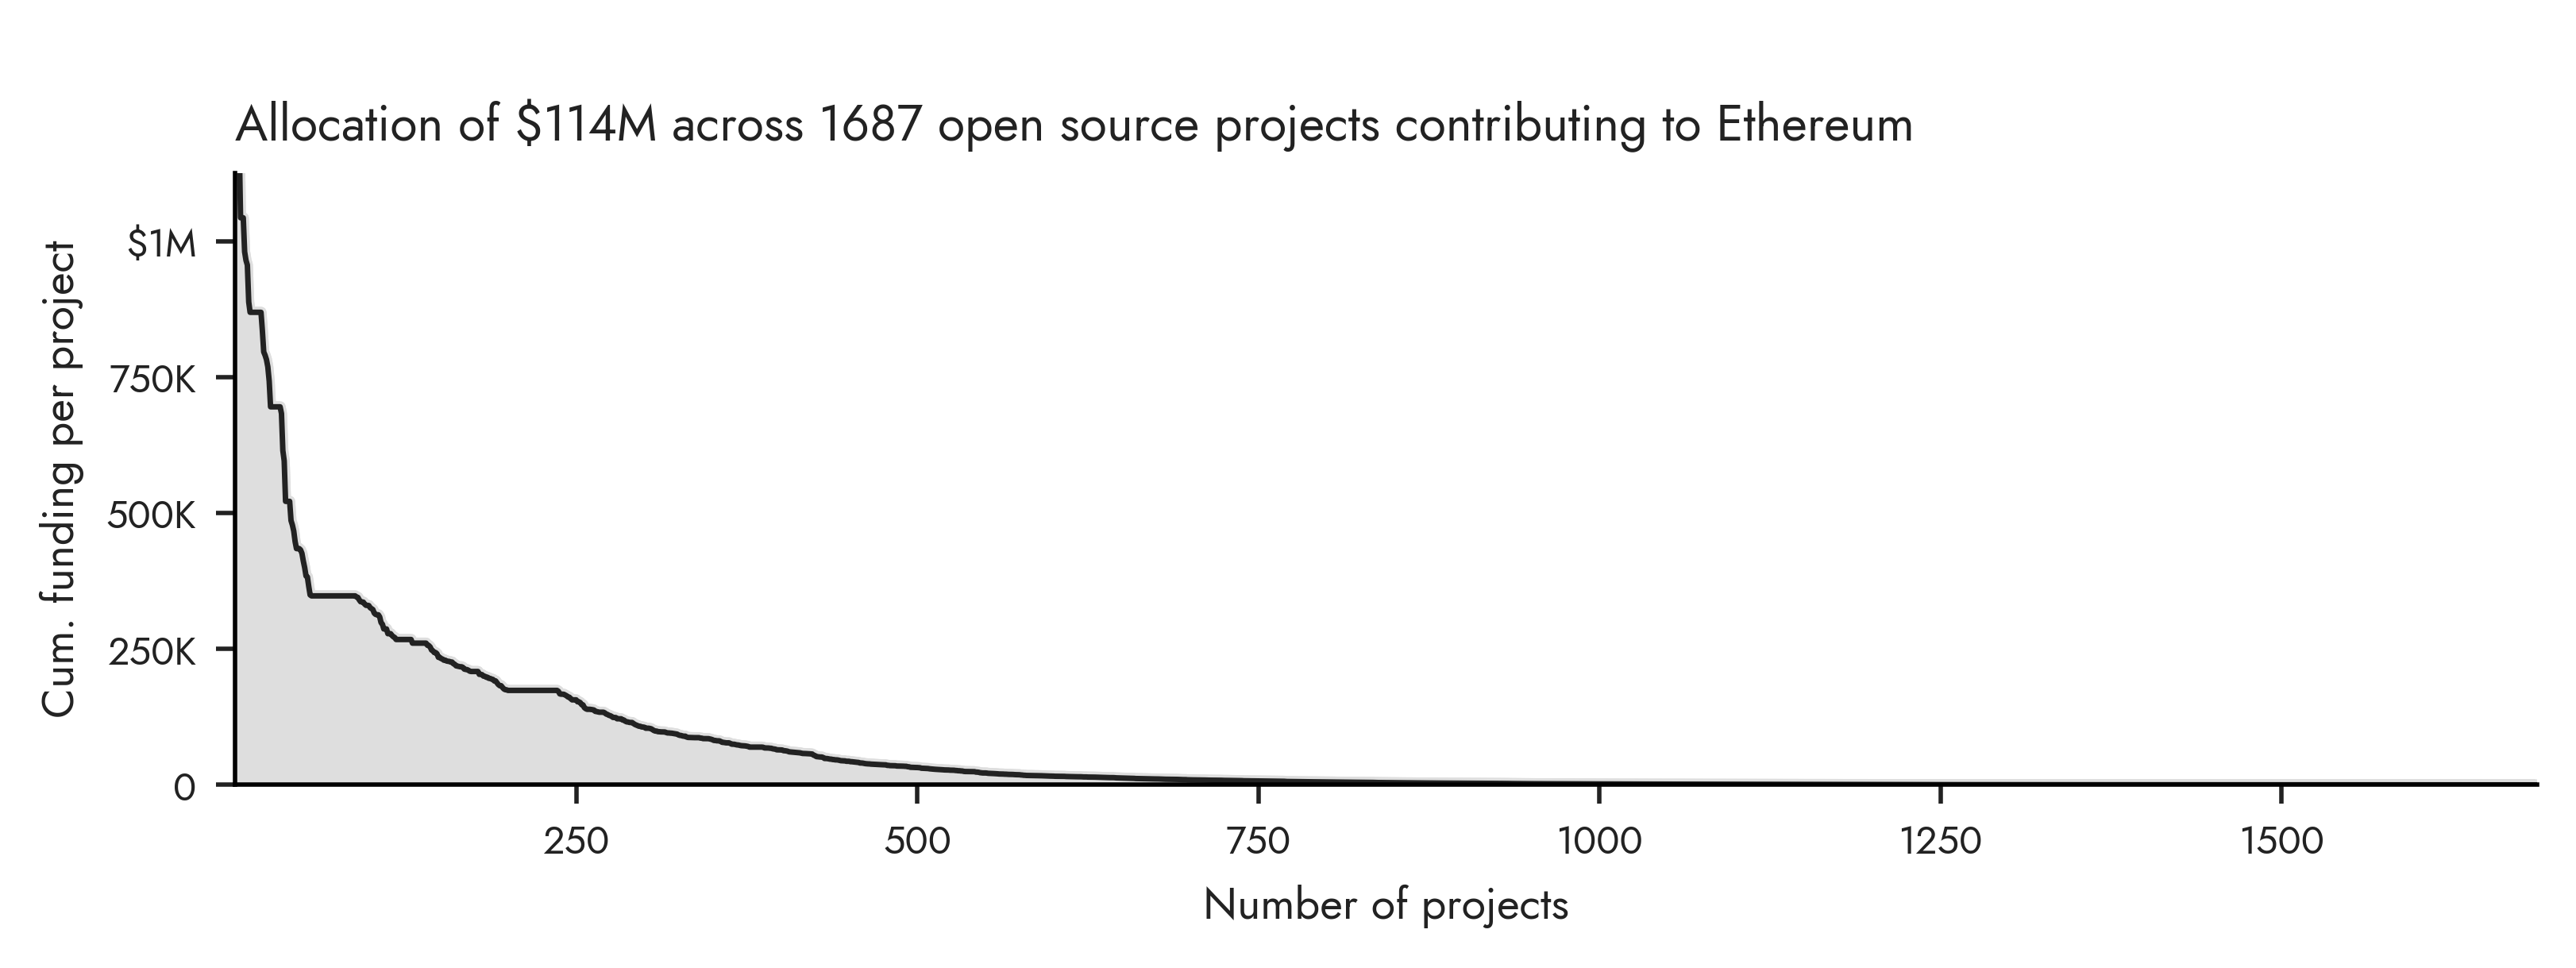

In [232]:
plt = prep_plot(fig_height=2)

n = len(df)
total = df[val_col].sum() / 1_000_000
title = f'\nAllocation of ${total:,.0f}M across {n} open source projects contributing to Ethereum'
    
(df[val_col]/1000).plot(kind='area', lw=2, color=GRAY3)
(df[val_col]/1000).plot(kind='line', lw=1, color=BLACK)

plt.xlim(0, n)
step = 250
xticks = [x for x in range(step, n, step)]
plt.xticks(xticks, xticks, fontsize=7)
plt.xlabel("Number of projects", fontsize=8)

plt.yticks([0, 250,500,750,1000], labels=["0", "250K", "500K", "750K", "$1M"], fontsize=7)
plt.ylim(0,1125)
plt.ylabel("Cum. funding per project", fontsize=8)

plt.title(title, loc='left', fontsize=9)
plt.savefig("oss_funding_longtail.png", bbox_inches="tight")

In [188]:
funding_to_projects = df.groupby('oss_project')['funding_usd'].sum().sort_values(ascending=False)
most_funded_projects = set(funding_to_projects.head(100).index)

included_projects = df.groupby('oss_project')['funding_usd'].count().sort_values(ascending=False)
most_included_projects = set(included_projects[included_projects>3].index)
selected_projects = most_included_projects.intersection(most_funded_projects)

df['oss_project'] = df['oss_project'].apply(lambda x: x if x in selected_projects else "Other")

In [216]:
def make_sankey_graph(df, cat_cols, value_col, height):

    # populate the Sankey data
    labelList = []
    nodeLabelList = []
    for catCol in cat_cols:
        labelListTemp = list(set(df[catCol].values))        
        labelList = labelList + labelListTemp
        nodeLabelList = nodeLabelList + labelListTemp            
    labelList = list(dict.fromkeys(labelList))

    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i], cat_cols[i+1], value_col]]
            sourceTargetDf.columns = ['source','target','value']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_col]]
            tempDf.columns = ['source','target','value']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'value':'sum'}).reset_index()

    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    sourceTargetDf['linkColor'] = sourceTargetDf['source'].apply(
        lambda x: GRAY3 if ('Retro' in x or 'Optimism' in x) else GRAY2
    )

    # create the Sankey diagram
    data = dict(
        type='sankey',
        orientation='h',
        domain=dict(x=[0,1], y=[0,1]),
        arrangement='snap',
        node=dict(
          thickness=20,
          line=dict(width=.25), 
          label=nodeLabelList,
          pad=5,
          color=GRAY1
        ),
        link=dict(
          source=sourceTargetDf['sourceID'],
          target=sourceTargetDf['targetID'],
          value=sourceTargetDf['value'],
          color=sourceTargetDf['linkColor']
        )
    )
    fig = dict(
        data=[data], 
        layout=dict(
            title_text=f"Overlap in funding sources for the top {df['oss_project'].nunique()} OSS projects",
            title_font_color=BLACK,
            font=dict(size=12, family="Jost"), 
            height=height
        )
    )
    return fig

In [217]:
fig = make_sankey_graph(df[df['oss_project'] != 'Other'], cat_cols, val_col, 600)
go.Figure(fig)

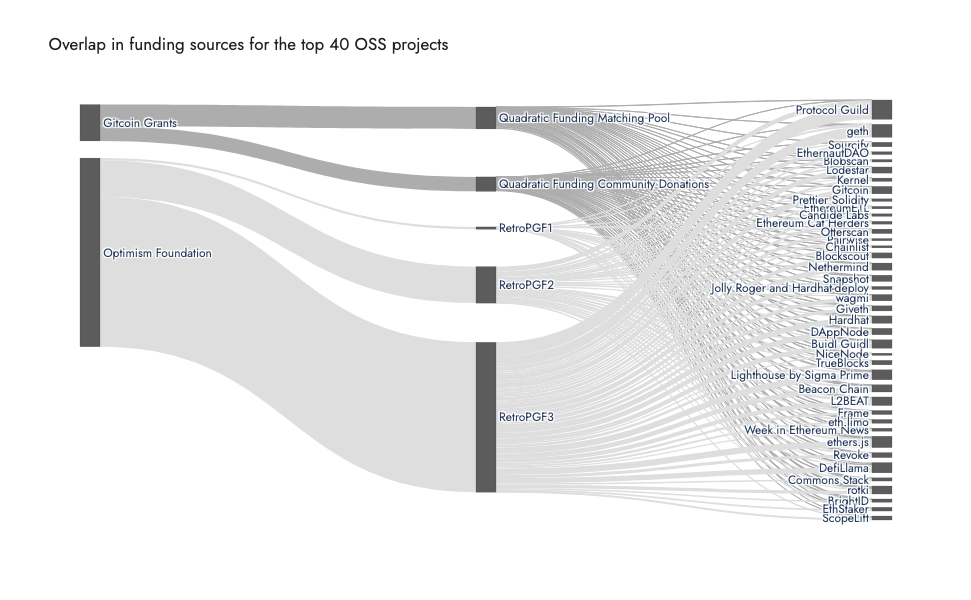